<img src="./img/hpe_logo.png" alt="HPE Logo" width="300">

<h1>Demo of the Enterprise Machine Learning Platform</h1>

<h5>Date: 07/21/23</h5>
<h5>Version: 1.0</h5>
<h5>Author(s): andrew.mendez

# Overview
* Walkthrough the E2E process of creating an MLOps at Scale pipeline using the Enterprise ML Platform
# Background:
* Data Versioning and Management
* Model Training
* Pipeline orchestration
* Model deployment and scalable inference
# Outline:
* Create Data Repo and Upload data
* Data Exploration
* Create Simple Baseline
* Train Model on MLDE
* Migrate Training and Inference into Scalable, Automated E2E Ops: Model deployment for inference
* Trigger End to End Pipeline Execution with updated better data
* Trigger End to End Pipeline Execution with updated dataset

<h3>Import modules and define functions</h3>
The cell below imports all modules and libraries required to run the demo.

In [1]:
# General modules
import os
import random
import numpy as np
import time
# Torch modules
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms

# Image modules
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import functions for downloading data
from load_data import download_pach_repo, download_data, get_train_transforms

# Import Determined Client
from determined.experimental import client as det
from determined import pytorch
from utils import calculate_coco_stats, visualize_coco_annotations, load_model
# Remove warnings
import warnings

import python_pachyderm
from python_pachyderm.service import pps_proto

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1>Interactive Experimentation </h1>

<img src="./img/platform_step1.png" alt="Enterprise Machine Learning platform architecture" width="850">

In [2]:
# Define variables for Pachyderm connection
pachyderm_host = "10.182.1.45"
pachyderm_port = 80
repo = "data"
branch = "master"
project = "object-detection-demo"
download_dir = "./data_downloaded"
token = " "

In [3]:
# create new project
client = python_pachyderm.Client(
    host=pachyderm_host, port=pachyderm_port, auth_token=token
)
# client.create_project(project)# Un-comment if you have not already created a project named: object-detection-demo


# Create Data Repo and Upload data to Pachyderm

In [4]:
client.create_repo(repo,project_name=project)# This line create a Pachyderm Repo


source_dir  = './data/'
# Populate the input repos
def insert_data(client,name,source_data_dir,project):
    print("Inserting {} data...".format(name))
    with client.commit(name, "master",project_name=project) as c:
        # data_dir = "{}_data".format(name)
        python_pachyderm.put_files(client, source_data_dir, c, "/")
                
        return c

d_commit = insert_data(client,repo,source_data_dir=source_dir,project=project)

# Wait for the commits to finish
print("Waiting for commits to finish...")
for commit in [client.wait_commit(c.id)[0] for c in [d_commit]]:
    print(commit)

Inserting data data...
Waiting for commits to finish...
commit {
  branch {
    repo {
      name: "data"
      type: "user"
      project {
        name: "object-detection-demo"
      }
    }
    name: "master"
  }
  id: "6aa8470780a544ca89d5659cb1832ab6"
}
origin {
  kind: USER
}
started {
  seconds: 1692892927
  nanos: 892940000
}
finishing {
  seconds: 1692892930
  nanos: 358340000
}
finished {
  seconds: 1692892930
  nanos: 675157000
}
size_bytes_upper_bound: 2953743
details {
  size_bytes: 2953743
  compacting_time {
    nanos: 101560512
  }
  validating_time {
    nanos: 207277797
  }
}



<h3>Inspect first version of data</h3>

In [5]:
# Call download, store paths in files
files = download_data(pachyderm_host, pachyderm_port, repo, branch, project, download_dir, token)

Starting to download dataset: data@master --> ./data_downloaded
Download operation successful!


<h3> Some light data exploration</h3>

In [6]:
FILE_PATH='./data_downloaded/train_images_rgb_no_neg_filt_32/train_640_02_filtered_32.json'
(num_annotations, 
 cat_ids, 
 cat_names, 
 annotations_per_category, 
 min_annotations, 
 max_annotations, 
 average_annotations, 
 min_annotation_area,
 max_annotation_area,
 avg_annotation_area,
 min_annotation_area_per_category, 
 max_annotation_area_per_category) = calculate_coco_stats(FILE_PATH)
print("Number of images:", num_annotations)
print(f"Number of Unique Categories: {len(cat_ids)}")
print(cat_ids)  # The IDs are not necessarily consecutive.

print("Category IDs:")
print("Categories Names: ", cat_names)
# Print or use annotations_per_category as needed
print("Number of annotations per category:")
print(annotations_per_category)
# Print or use the calculated metrics as needed
print("Minimum number of annotations for an image:", min_annotations)
print("Maximum number of annotations in an image:", max_annotations)
print("Average number of annotations per image:", average_annotations)

print("Minimum annotation area:", min_annotation_area)
print("Maximum annotation area:", max_annotation_area)
print("Average annotation area:", avg_annotation_area)

print("\nMinimum annotation area per category:")
print(min_annotation_area_per_category)

print("\nMaximum annotation area per category:")
print(max_annotation_area_per_category)

COCO annotation file:  ./data_downloaded/train_images_rgb_no_neg_filt_32/train_640_02_filtered_32.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of images: 10
Number of Unique Categories: 2
[1, 2]
Category IDs:
Categories Names:  ['Fixed-wing Aircraft', 'Cargo Plane']
Number of annotations per category:
{'Fixed-wing Aircraft': 8, 'Cargo Plane': 2}
Minimum number of annotations for an image: 1
Maximum number of annotations in an image: 2
Average number of annotations per image: 1.1111111111111112
Minimum annotation area: 588
Maximum annotation area: 14820
Average annotation area: 5086.6

Minimum annotation area per category:
{'Cargo Plane': 5520, 'Fixed-wing Aircraft': 588}

Maximum annotation area per category:
{'Cargo Plane': 14760, 'Fixed-wing Aircraft': 14820}


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


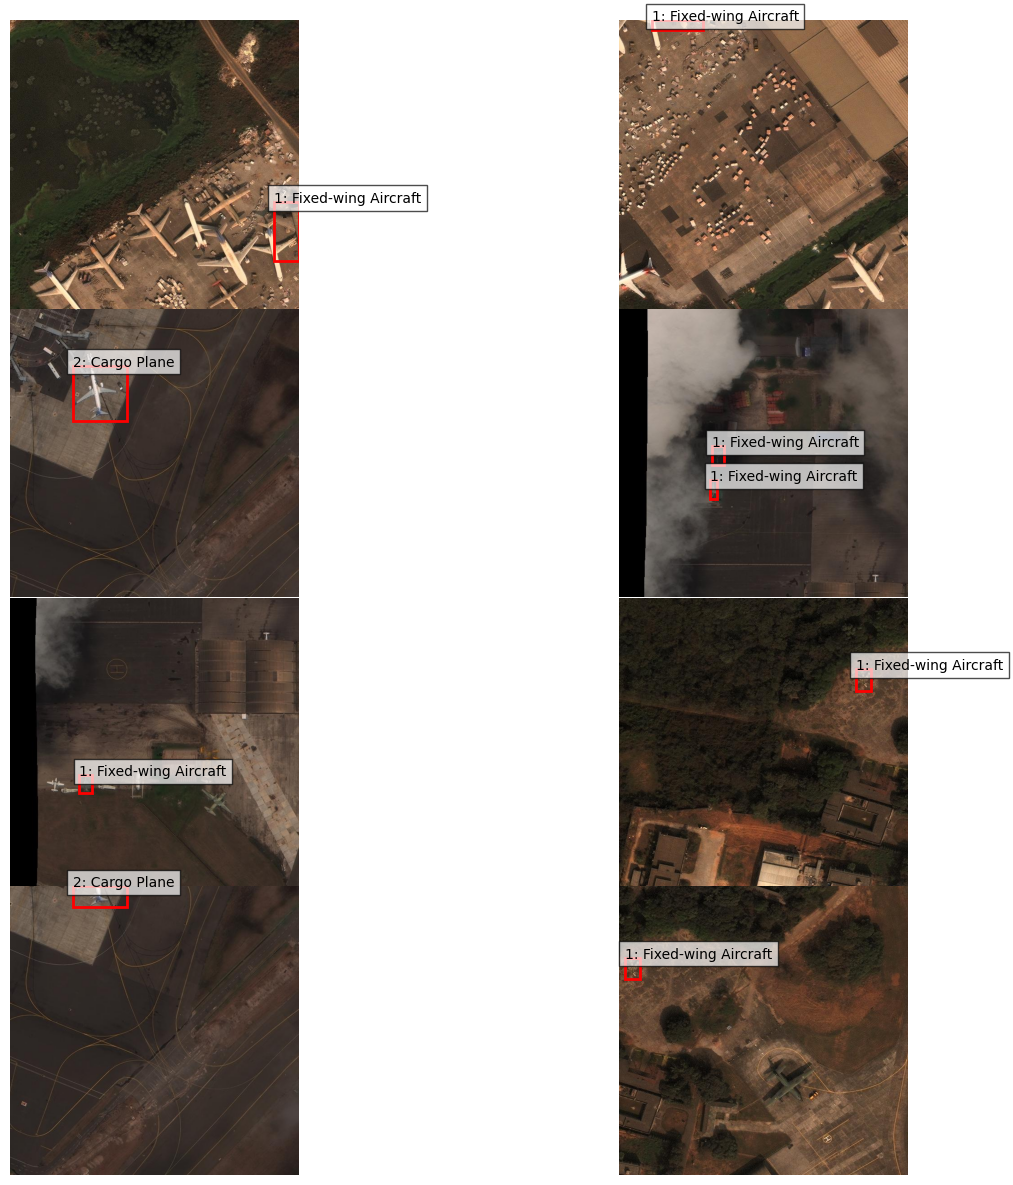

In [7]:
coco_ann_file_path = './data/train_images_rgb_no_neg_filt_32/train_640_02_filtered_32.json'
coco_img_dir = './data/train_images_rgb_no_neg_filt_32/train_images_640_02_filt_32'
visualize_coco_annotations(coco_ann_file_path, coco_img_dir)

In [8]:
import datetime
import os
import time

import torch
import torch.utils.data
import torchvision
import torchvision.models.detection
import torchvision.models.detection.mask_rcnn

# from detection_utils.coco import get_coco, get_coco_kp
from detection_utils.data import build_xview_dataset_filtered
from detection_utils.group_by_aspect_ratio import GroupedBatchSampler, create_aspect_ratio_groups
from detection_utils.engine import train_and_eval, eval_model

# from detection_utils.train import get_dataset, get_transform
from detection_utils.models import build_frcnn_model
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
from attrdict import AttrDict
import matplotlib.pyplot as plt

TORCHVISION_VERSION:  0.13.0+cu113 /opt/conda/lib/python3.8/site-packages/torchvision/__init__.py
TORCH_VERSION:  1.12.0+cu113 /opt/conda/lib/python3.8/site-packages/torch/__init__.py


<h2> Create Simple Baseline</h2>

### Create data set class (inherit from Pytorch dataset)
```python
class LocalBackend:
    """
    This class will load data from harddrive.
    COCO dataset will be downloaded from source in model_def.py if
    local backend is specified.
    """

    def __init__(self, outdir):
        assert os.path.isdir(outdir)
        self.outdir = outdir

    def get(self, filepath):
        with open(os.path.join(self.outdir, filepath), "rb") as f:
            img_str = f.read()
        return img_str


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        backend,
        root_dir,
        img_folder,
        ann_file,
        transforms,
        return_masks,
        catIds=[],
    ):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.img_folder = img_folder
        self._transforms = transforms
        self.prepare = ConvertCocoPolysToMask(return_masks)
        elif backend == "local":
            self.backend = LocalBackend(root_dir)
        else:
            raise NotImplementedError

        self.catIds = catIds
        self.catIds = self.coco.getCatIds()
        '''
        Remapping to set background class to zero, so can support FasterRCNN models
        '''
        self.catIdtoCls = {
            catId: i+1 for i, catId in zip(range(len(self.catIds)), self.catIds)
        }
        self.clstoCatId = {
            v:k for k,v in self.catIdtoCls.items()
        }
        self.num_classes = len(list(self.catIdtoCls.values()))+1

    def __getitem__(self, idx):
        coco = self.coco
        img_id = self.ids[idx]
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=self.catIds)
        target = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]["file_name"]
        img_bytes = BytesIO(self.backend.get(os.path.join(self.img_folder, path)))

        img = Image.open(img_bytes).convert("RGB")
        # img.save('test.png')
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        img, target = self.prepare(img, target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        target["labels"] = torch.tensor(
                [self.catIdtoCls[l.item()] for l in target["labels"]], dtype=torch.int64
            )

        return img, target

    def __len__(self):
        return len(self.ids)
```

In [9]:
def unwrap_collate_fn(batch):
    batch = list(zip(*batch))
    return tuple(batch)

data_dir = os.path.join('.', "data_downloaded")
print(data_dir)
dataset, num_classes = build_xview_dataset_filtered(image_set='train',args=AttrDict({
                                                'data_dir':data_dir,
                                                'backend':'local',
                                                'masks': None,
                                                }))
print("--num_classes: ",num_classes)
data_loader = torch.utils.data.DataLoader(
                                 dataset, 
                                 batch_size=4,
                                 batch_sampler=None,
                                 shuffle=True,
                                 num_workers=1, 
                                 collate_fn=unwrap_collate_fn)
print(data_dir)
dataset_test, _ = build_xview_dataset_filtered(image_set='val',args=AttrDict({
                                                'data_dir':data_dir,
                                                'backend':'local',
                                                'masks': None,
                                                }))

./data_downloaded
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
--num_classes:  3
./data_downloaded
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


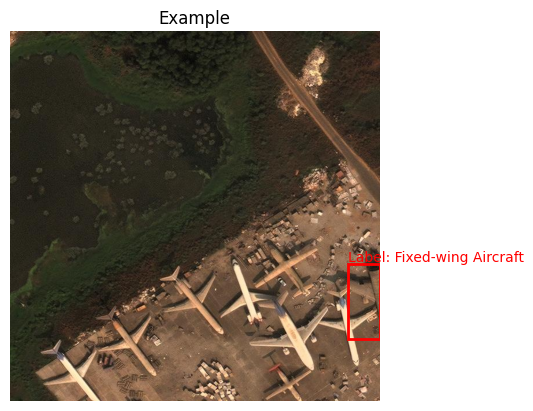

In [10]:
# Labels used to translate category_id
det_labels = ["Fixed-wing Aircraft", "Cargo Plane"]
# Get one sample from the data set and show the image for validation
for sample in data_loader:
    img, targets = sample
    img = img[0].cpu()
    boxes = targets[0]['boxes'].cpu().numpy()
    labels = targets[0]['labels'].cpu().numpy()
    fig, ax = plt.subplots(1)
    ax.set_title("Example")
    ax.imshow(np.clip(img.permute(1, 2, 0), 0, 1))
    # Plot bounding boxes as rectangles on the image
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, f'Label: {det_labels[label-1]}', color='red', fontsize=10)

    plt.axis('off')
    plt.show()
    break

<h3>Step 4: Create DataLoader and model</h3>

In [11]:
# Create pytorch data loader
data_loader = torch.utils.data.DataLoader(
                                 dataset, 
                                 batch_size=4,
                                 shuffle=True,
                                 num_workers=1, 
                                 collate_fn=unwrap_collate_fn)
print("NUMBER OF BATCHES IN COCO: ",len(data_loader))# 59143, 7392 for mini coco
data_loader_test = torch.utils.data.DataLoader(
                            dataset_test,
                            batch_size=4,
                            shuffle=False,
                            num_workers=1,
                            collate_fn=unwrap_collate_fn)

# Load FasterRCNN model (untrained) to GPU
model = build_frcnn_model(3).cuda()
device = 'cuda'

# Setup loss function and optimizer. Note: the loss function is built into the torchvision FasterRCNN model
optimizer = torch.optim.SGD(
            model.parameters(),
            lr=0.02,
            momentum=0.9,
            weight_decay=1e-4
        )

NUMBER OF BATCHES IN COCO:  3
Loading pretrained model...


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /run/determined/workdir/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:06<00:00, 26.2MB/s] 


<h3>Run some training (overfitting on one batch)</h3>

In [12]:
# Create iterator for data loader
dataiter = iter(data_loader)

# Get a single batch to overfit on
inputs, targets = dataiter.next()

In [13]:
# Fit model on dataset 2 times
import time
loss_dict = {'loss_classifier':1, 'loss_box_reg': 1, 'loss_objectness': 1, 'loss_rpn_box_reg': 1, 'tr_time': 1}
# Initialize running sums and counts for each loss component
running_sums = {key: 0.0 for key in loss_dict.keys()}
running_counts = {key: 0 for key in loss_dict.keys()}
NUM_EPOCHS=40
for e in range(NUM_EPOCHS):
    for ind, batch in enumerate(data_loader):
        batch_time_start = time.time()
        images, targets = batch
        images = list(image.to(device, non_blocking=True) for image in images)
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses_reduced = sum(loss for loss in loss_dict.values())
        loss_value = losses_reduced.item()
        optimizer.zero_grad()
        losses_reduced.backward()
        optimizer.step()
        total_batch_time = time.time() - batch_time_start

        # Update running sums and counts for each loss component
        for key, value in loss_dict.items():
            running_sums[key] += value.item()
            running_counts[key] += 1

        # Calculate the running mean for each loss component
        running_means = {key: running_sums[key] / running_counts[key] for key in loss_dict.keys()}

        # Add the total batch time to the loss_dict
        running_means['tr_time'] = total_batch_time
        if ind%4 == 0:
            # Print the contents in a nice, formatted manner
            print(f"Epoch {e}/{NUM_EPOCHS}")
            print(f"{ind}/{len(data_loader)} ", end="")
            for key, value in running_means.items():
                if key not in ['accuracy', 'val_loss', 'val_accuracy']:
                    print(f"{key}: {value:.4f} - ", end="")
            print()
        # break

print('\nFinished Training')

Epoch 0/40
0/3 loss_classifier: 1.5633 - loss_box_reg: 0.0893 - loss_objectness: 0.0921 - loss_rpn_box_reg: 0.0035 - tr_time: 1.3703 - 
Epoch 1/40
0/3 loss_classifier: 0.5131 - loss_box_reg: 0.0644 - loss_objectness: 0.0833 - loss_rpn_box_reg: 0.0070 - tr_time: 0.0764 - 
Epoch 2/40
0/3 loss_classifier: 0.3845 - loss_box_reg: 0.0870 - loss_objectness: 0.0802 - loss_rpn_box_reg: 0.0065 - tr_time: 0.0755 - 
Epoch 3/40
0/3 loss_classifier: 0.3646 - loss_box_reg: 0.0938 - loss_objectness: 0.0618 - loss_rpn_box_reg: 0.0064 - tr_time: 0.0778 - 
Epoch 4/40
0/3 loss_classifier: 0.3031 - loss_box_reg: 0.0978 - loss_objectness: 0.0516 - loss_rpn_box_reg: 0.0063 - tr_time: 0.0756 - 
Epoch 5/40
0/3 loss_classifier: 0.2656 - loss_box_reg: 0.1010 - loss_objectness: 0.0441 - loss_rpn_box_reg: 0.0061 - tr_time: 0.0762 - 
Epoch 6/40
0/3 loss_classifier: 0.2364 - loss_box_reg: 0.1020 - loss_objectness: 0.0380 - loss_rpn_box_reg: 0.0059 - tr_time: 0.0756 - 
Epoch 7/40
0/3 loss_classifier: 0.2166 - loss_bo

<h3> Validate model trained in notebook</h3>

4
{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}
{'boxes': tensor([[327.5307, 395.4106, 398.7509, 496.1478],
        [320.7301, 403.3606, 417.5535, 491.4837]], device='cuda:0'), 'labels': tensor([1, 2], device='cuda:0'), 'scores': tensor([0.8152, 0.1102], device='cuda:0')}
{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}
{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}


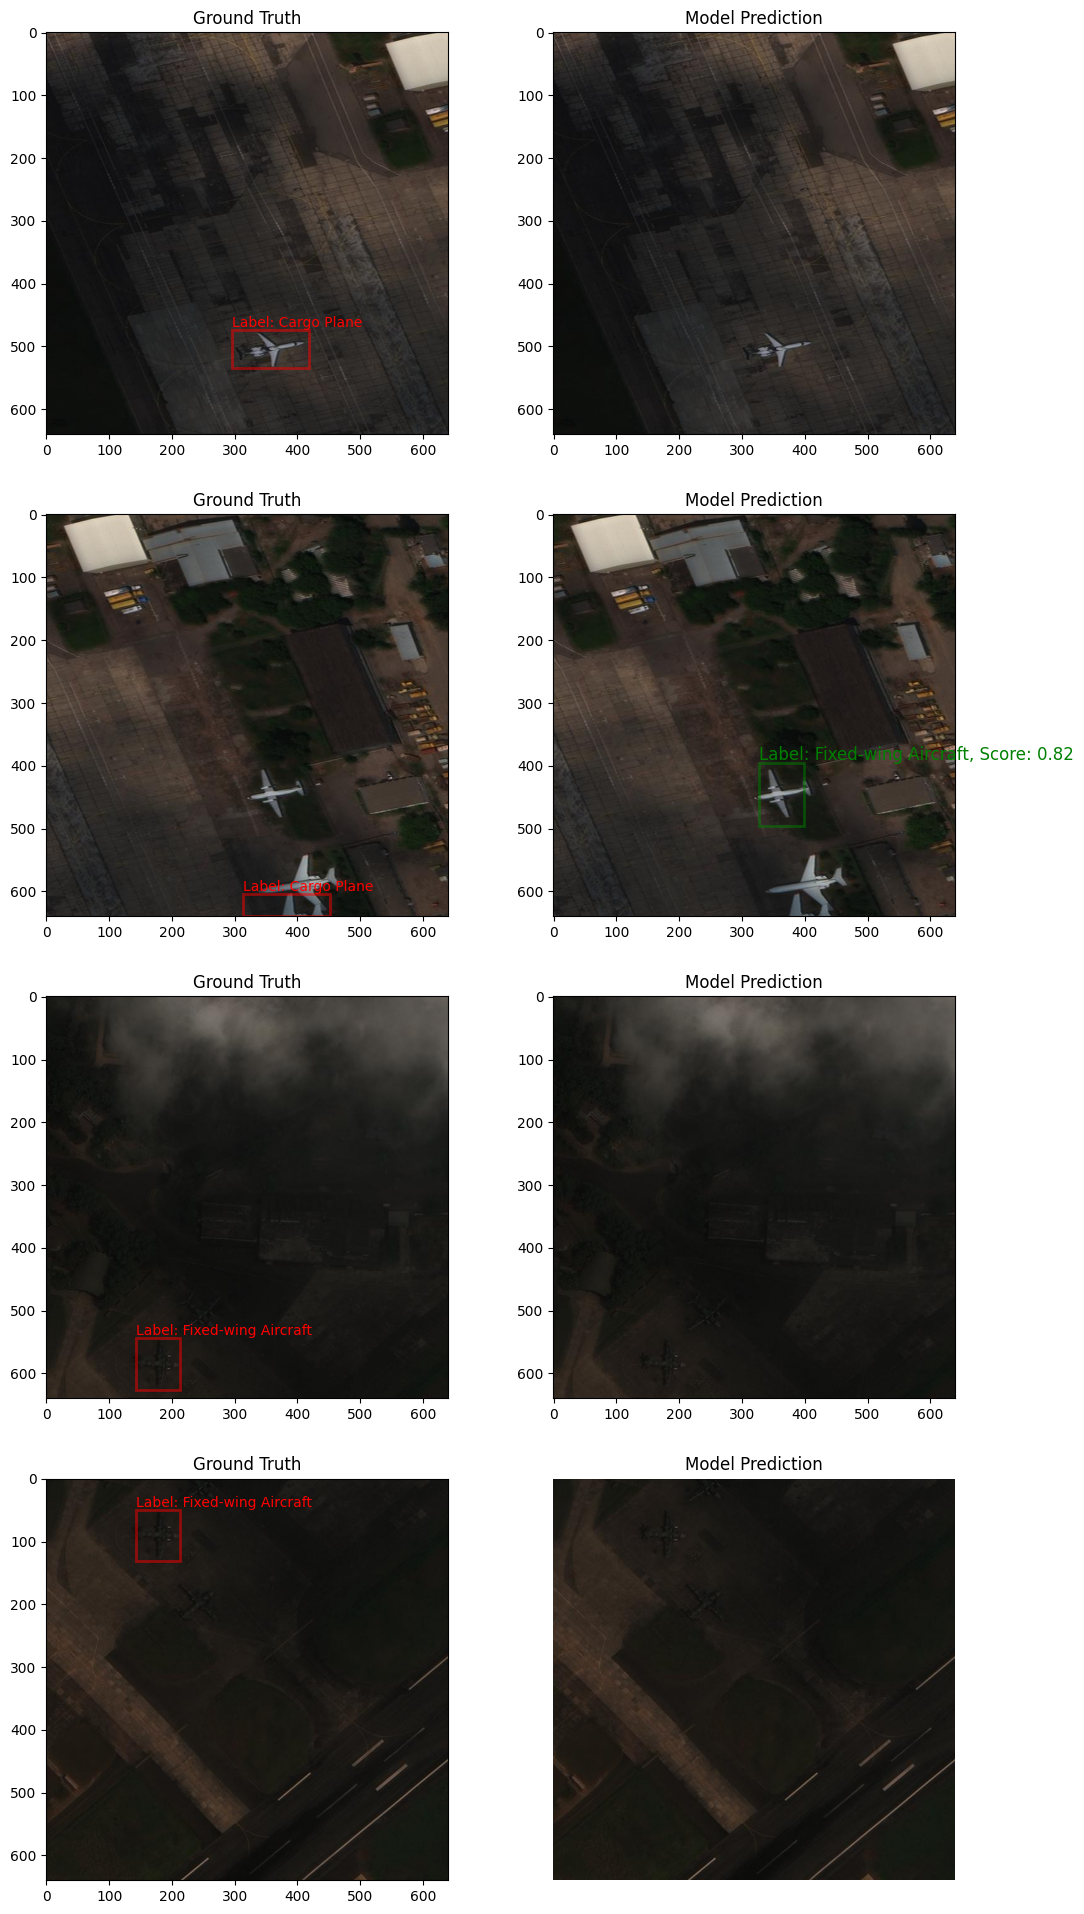

In [14]:
import torch
import matplotlib.pyplot as plt

model.eval()
det_labels = ["Fixed-wing Aircraft", "Cargo Plane"]

with torch.no_grad():
    for sample in data_loader_test:
        images, targets = sample
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        print(len(images))
        fig, axs = plt.subplots(len(images), 2, figsize=(12, 6 * len(images)))

        for idx, (img, target) in enumerate(zip(images, targets)):
            img_np = img.clone().cpu().permute(1, 2, 0).numpy()

            # Ground truth
            axs[idx, 0].set_title("Ground Truth")
            axs[idx, 0].imshow(np.clip(img_np, 0, 1))
            boxes_gt = target['boxes'].cpu().numpy()
            labels_gt = target['labels'].cpu().numpy()
            # print(boxes_gt)
            for box, label in zip(boxes_gt, labels_gt):
                x_min, y_min, x_max, y_max = box
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     fill=False, edgecolor='red', linewidth=2, alpha=0.5)
                axs[idx, 0].add_patch(rect)
                axs[idx, 0].text(x_min, y_min - 5, f'Label: {det_labels[label-1]}', color='red', fontsize=10)

            # Model prediction
            axs[idx, 1].set_title("Model Prediction")
            axs[idx, 1].imshow(np.clip(img_np, 0, 1))
            outputs = model([img])
            print(outputs[0])
            if outputs[0]['boxes'].nelement() !=0:
                outputs = [{k: v[0].to('cpu') for k, v in output.items()} for output in outputs]
                boxes_pred = [outputs[0]['boxes'].numpy()] if not isinstance(outputs[0]['boxes'].numpy(),list) else outputs[0]['boxes'].numpy()
                labels_pred = [outputs[0]['labels'].numpy()] if not isinstance(outputs[0]['labels'].numpy(),list) else outputs[0]['labels'].numpy()
                scores_pred = [outputs[0]['scores'].numpy()] if not isinstance(outputs[0]['scores'].numpy(),list) else outputs[0]['scores'].numpy()

                # Plot bounding boxes with scores greater than 0.05 as rectangles on the image
                # print(boxes_pred, labels_pred, scores_pred)
                for box, label, score in zip(boxes_pred, labels_pred, scores_pred):
                    if score > 0.005:
                        x_min, y_min, x_max, y_max = box
                        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                             fill=False, edgecolor='green', linewidth=2, alpha=0.5)
                        axs[idx, 1].add_patch(rect)
                        axs[idx, 1].text(x_min, y_min - 5, f'Label: {det_labels[label-1]}, Score: {score:.2f}', color='green', fontsize=12)

                plt.axis('off')
                # plt.show()
            else:
                pass
                # plt.axis('off')
        plt.show()
            # break


<h1>Migrate Training into MLDE</h1>

<img src="./img/platform_step2.png" alt="Enterprise Machine Learning platform architecture" width="850">

<h3>Connect to our cluster and submit experiment on our AI at Scale Training platform</h3>
This will take a few minutes because we are completing the following tasks:

* Uploading experiment artifacts
* Cluster allocates GPU resources and downloads docker container that was specified in experiment config 
* some additional python packages need to be installed
* then training kicks off

In [15]:
# Create experiment using yaml file and submit to MLDE
exp = det.create_experiment(config="./experiment/const.yaml", model_dir="./experiment/")
print(f"started experiment {exp.id}")

# Wait for experiment to complete and print exit status
exit_status = exp.wait()
print(f"experiment completed with status {exit_status}")

# Get the best Checkpoint of the experiment and print uuid
best_checkpoint = exp.top_checkpoint()
best_checkpoint_uuid = best_checkpoint.uuid
print(f"Best checkpoint was {best_checkpoint_uuid}")

Preparing files to send to master... 223.8KB and 35 files
started experiment 2218
experiment completed with status ExperimentState.COMPLETED
Best checkpoint was 5ce84d33-9ff6-4dc8-b603-52343c5b32a2


<h3>Validate model trained on MLDE</h3>

In [19]:
# Pull model checkpoint from Determined.AI using UUID
best_checkpoint = det.get_checkpoint(best_checkpoint_uuid)
print("Best checkpoint retrieved.")

Best checkpoint retrieved.


In [20]:
# Load checkpoint to model
path = best_checkpoint.download()
print(path)
trained_model = build_frcnn_model(3)
trained_model = load_model(trained_model,path)
# dog_cat_trained = pytorch.trained_model(path).model
print("Checkpoint loaded into model.")

checkpoints/5ce84d33-9ff6-4dc8-b603-52343c5b32a2
Loading pretrained model...
Checkpoint loaded into model.


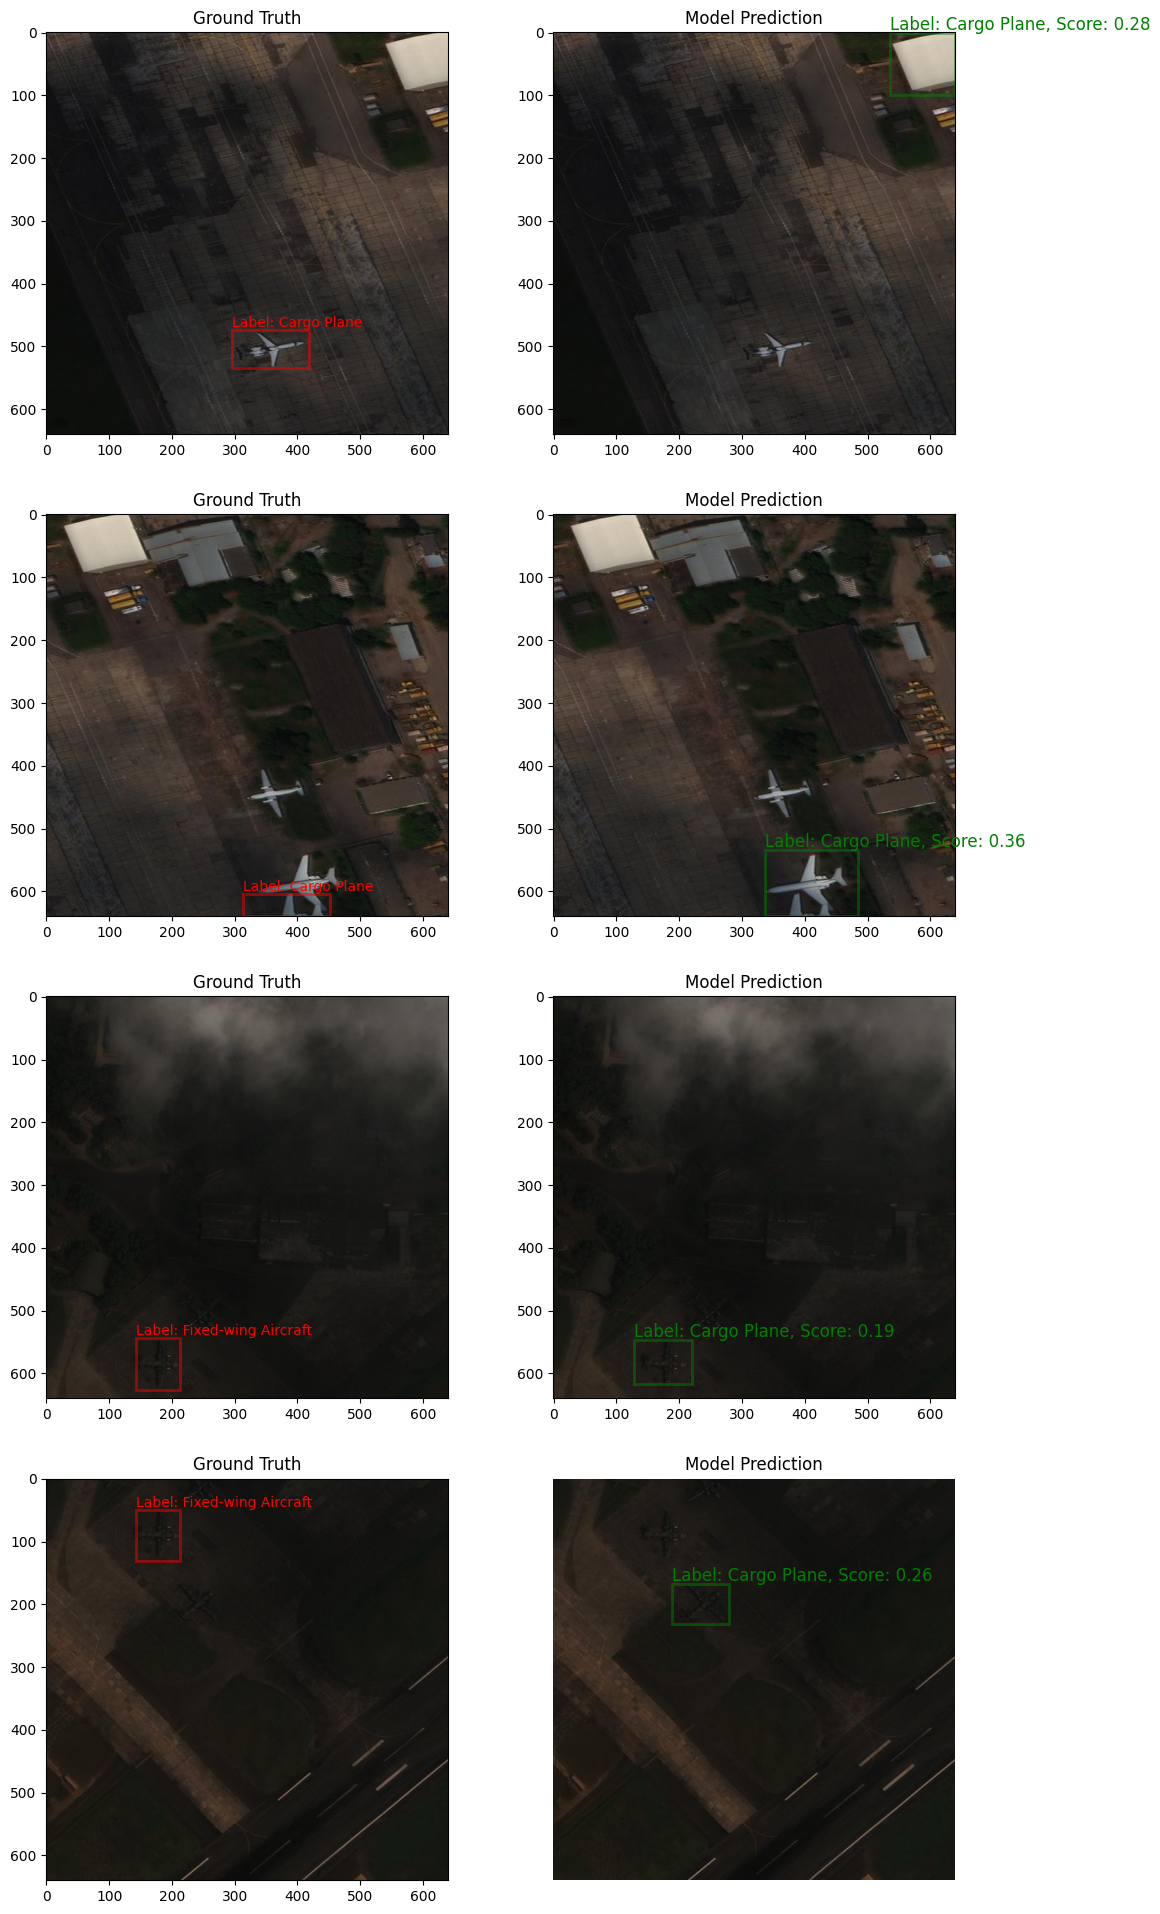

In [21]:
import torch
import matplotlib.pyplot as plt
trained_model.to('cuda')
trained_model.eval()
det_labels = ["Fixed-wing Aircraft", "Cargo Plane"]
device = 'cuda'
with torch.no_grad():
    for sample in data_loader_test:
        images, targets = sample
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        fig, axs = plt.subplots(len(images), 2, figsize=(12, 6 * len(images)))

        for idx, (img, target) in enumerate(zip(images, targets)):
            img_np = img.clone().cpu().permute(1, 2, 0).numpy()

            # Ground truth
            axs[idx, 0].set_title("Ground Truth")
            axs[idx, 0].imshow(np.clip(img_np, 0, 1))
            boxes_gt = target['boxes'].cpu().numpy()
            labels_gt = target['labels'].cpu().numpy()
            # print(boxes_gt)
            for box, label in zip(boxes_gt, labels_gt):
                x_min, y_min, x_max, y_max = box
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     fill=False, edgecolor='red', linewidth=2, alpha=0.5)
                axs[idx, 0].add_patch(rect)
                axs[idx, 0].text(x_min, y_min - 5, f'Label: {det_labels[label-1]}', color='red', fontsize=10)

            # Model prediction
            axs[idx, 1].set_title("Model Prediction")
            axs[idx, 1].imshow(np.clip(img_np, 0, 1))
            outputs = trained_model([img])
            outputs = [{k: v[0].to('cpu') for k, v in output.items()} for output in outputs]
            boxes_pred = [outputs[0]['boxes'].numpy()] if not isinstance(outputs[0]['boxes'].numpy(),list) else outputs[0]['boxes'].numpy()
            labels_pred = [outputs[0]['labels'].numpy()] if not isinstance(outputs[0]['labels'].numpy(),list) else outputs[0]['labels'].numpy()
            scores_pred = [outputs[0]['scores'].numpy()] if not isinstance(outputs[0]['scores'].numpy(),list) else outputs[0]['scores'].numpy()

            # Plot bounding boxes with scores greater than 0.05 as rectangles on the image
            # print(boxes_pred, labels_pred, scores_pred)
            for box, label, score in zip(boxes_pred, labels_pred, scores_pred):
                if score > 0.05:
                    x_min, y_min, x_max, y_max = box
                    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                         fill=False, edgecolor='green', linewidth=2, alpha=0.5)
                    axs[idx, 1].add_patch(rect)
                    axs[idx, 1].text(x_min, y_min - 5, f'Label: {det_labels[label-1]}, Score: {score:.2f}', color='green', fontsize=12)

        plt.axis('off')
        plt.show()
        break


<h1>Migrate Training and Inference into Scalable, Automated E2E Ops: Model deployment for inference</h1>

<img src="./img/platform_step3.png" alt="Enterprise Machine Learning platform architecture" width="850">

In [22]:
client = python_pachyderm.Client(
    host=pachyderm_host, port=pachyderm_port, auth_token=token
)

In [23]:
# Create Pipeline:
import json
PATH = 'pdk-use-cases-dev/object-detection/pipelines/training-pipeline.json'
with open(PATH,'r') as file:
    spec_d = json.loads(file.read())
    spec = python_pachyderm.parse_dict_pipeline_spec(spec_d)
spec

pipeline {
  name: "training"
}
transform {
  image: "vmtyler/pdk:train_0.1.1"
  cmd: "/bin/sh"
  secrets {
    name: "pipeline-secret"
    key: "det_master"
    env_var: "DET_MASTER"
  }
  secrets {
    name: "pipeline-secret"
    key: "det_user"
    env_var: "DET_USER"
  }
  secrets {
    name: "pipeline-secret"
    key: "det_password"
    env_var: "DET_PASSWORD"
  }
  secrets {
    name: "pipeline-secret"
    key: "pac_token"
    env_var: "PAC_TOKEN"
  }
  stdin: "python train.py --git-url https://git@github.com:/interactivetech/pdk-use-cases-dev.git --git-ref main --sub-dir object-detection/experiment --config const.yaml --repo data --model sat-detection --project object-detection-demo"
}
input {
  pfs {
    name: "data"
    repo: "data"
    branch: "master"
    glob: "/"
    empty_files: true
  }
}
description: "Detects changed files into a repository and triggers a retraining on that dataset"
pod_patch: "[{ \"op\": \"add\", \"path\": \"/tolerations\", \"value\": [ { \"key\": \"ac

In [24]:
client.create_pipeline(
    pipeline_name=spec.pipeline.name,
    transform=spec.transform,
    project_name=project,
    input=spec.input,
    description=spec.description,
    pod_patch = spec.pod_patch
)

In [25]:
import json
PATH = 'pdk-use-cases-dev/object-detection/pipelines/deployment-pipeline.json'
with open(PATH,'r') as file:
    spec_d = json.loads(file.read())
    spec = python_pachyderm.parse_dict_pipeline_spec(spec_d)
spec

pipeline {
  name: "deploy"
}
transform {
  image: "mendeza/pdk:deploy_0.0.23"
  cmd: "/bin/sh"
  secrets {
    name: "pipeline-secret"
    key: "det_master"
    env_var: "DET_MASTER"
  }
  secrets {
    name: "pipeline-secret"
    key: "det_user"
    env_var: "DET_USER"
  }
  secrets {
    name: "pipeline-secret"
    key: "det_password"
    env_var: "DET_PASSWORD"
  }
  secrets {
    name: "pipeline-secret"
    key: "kserve_namespace"
    env_var: "KSERVE_NAMESPACE"
  }
  stdin: "python deploy.py --k8s-config-file /lus/aiholus1/disk/andrew.mendez/k8s-a.config --deployment-name detection-deploy --service-account-name pach-deploy --tolerations accelerator=Tesla-T4 --resource-requests cpu=10,memory=8Gi --resource-limits cpu=10,memory=8Gi"
}
resource_limits {
  gpu {
    type: "nvidia.com/gpu"
    number: 1
  }
}
input {
  pfs {
    name: "data"
    repo: "training"
    branch: "master"
    glob: "/"
  }
}
description: "Deploys a model into production via the KServe Python SDK."
pod_patch

In [26]:
client.create_pipeline(
    pipeline_name=spec.pipeline.name,
    transform=spec.transform,
    project_name=project,
    input=spec.input,
    description=spec.description,
    pod_patch = spec.pod_patch
)

Show how on the MLDM pipeline UI, both training and deployment pipeline are created. We will need to wait a few minutes for each pipeline step to complete, 

## Lets Look at model predicitions with our deployed model in another notebook!

# Trigger End to End Pipeline Execution with updated dataset

In [24]:
import python_pachyderm
from python_pachyderm.service import pps_proto

In [25]:
# Define variables for Pachyderm connection
pachyderm_host = "10.182.1.45"
pachyderm_port = 80
repo = "data"
branch = "master"
project = "object-detection-demo"
download_dir = "./xview_dataset_full"
token = " "

## Here we have a new version of the dataset that includes more labels (88 annotations)

In [26]:
FILE_PATH=f'{download_dir}/train_images_rgb_no_neg_filt_32/train_640_02_filtered_32.json'
(num_annotations, 
 cat_ids, 
 cat_names, 
 annotations_per_category, 
 min_annotations, 
 max_annotations, 
 average_annotations, 
 min_annotation_area,
 max_annotation_area,
 avg_annotation_area,
 min_annotation_area_per_category, 
 max_annotation_area_per_category) = calculate_coco_stats(FILE_PATH)
print("Number of images:", num_annotations)
print(f"Number of Unique Categories: {len(cat_ids)}")
print(cat_ids)  # The IDs are not necessarily consecutive.

print("Category IDs:")
print("Categories Names: ", cat_names)
# Print or use annotations_per_category as needed
print("Number of annotations per category:")
print(annotations_per_category)
# Print or use the calculated metrics as needed
print("Minimum number of annotations for an image:", min_annotations)
print("Maximum number of annotations in an image:", max_annotations)
print("Average number of annotations per image:", average_annotations)

print("Minimum annotation area:", min_annotation_area)
print("Maximum annotation area:", max_annotation_area)
print("Average annotation area:", avg_annotation_area)

print("\nMinimum annotation area per category:")
print(min_annotation_area_per_category)

print("\nMaximum annotation area per category:")
print(max_annotation_area_per_category)

COCO annotation file:  ./xview_dataset_full/train_images_rgb_no_neg_filt_32/train_640_02_filtered_32.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of images: 88
Number of Unique Categories: 2
[1, 2]
Category IDs:
Categories Names:  ['Fixed-wing Aircraft', 'Cargo Plane']
Number of annotations per category:
{'Fixed-wing Aircraft': 8, 'Cargo Plane': 80}
Minimum number of annotations for an image: 1
Maximum number of annotations in an image: 12
Average number of annotations per image: 2.75
Minimum annotation area: 444
Maximum annotation area: 42200
Average annotation area: 9446.431818181818

Minimum annotation area per category:
{'Cargo Plane': 444, 'Fixed-wing Aircraft': 588}

Maximum annotation area per category:
{'Cargo Plane': 42200, 'Fixed-wing Aircraft': 14820}


We will show how when we upload an updated version of our dataset, the entire end-to-end training and deployment pipeline kicks off

In [27]:
client = python_pachyderm.Client(
    host=pachyderm_host, port=pachyderm_port, auth_token=token
)
def insert_data(client,name,source_data_dir,project):
    print("Inserting {} data...".format(name))
    with client.commit(name, "master",project_name=project) as c:
        # data_dir = "{}_data".format(name)
        python_pachyderm.put_files(client, source_data_dir, c, "/")
                
        return c
# name = "objdet-data2"
d_commit = insert_data(client,repo,source_data_dir=source_dir,project=project)

# Wait for the commits to finish
print("Waiting for commits to finish...")
for commit in [client.wait_commit(c.id)[0] for c in [d_commit]]:
    print(commit)

Inserting data data...
Waiting for commits to finish...
commit {
  branch {
    repo {
      name: "deploy"
      type: "spec"
      project {
        name: "object-detection-demo"
      }
    }
    name: "master"
  }
  id: "2536301da7a641adbd210b347870f6ee"
}
origin {
  kind: USER
}
started {
  seconds: 1692828568
  nanos: 747009000
}
finishing {
  seconds: 1692828568
  nanos: 747009000
}
finished {
  seconds: 1692828569
  nanos: 137528000
}
details {
  compacting_time {
    nanos: 128345609
  }
  validating_time {
    nanos: 127258103
  }
}



## Run cell to clean up environment

In [28]:
# delete pachyderm pipelines
import json

PATH = 'pdk-use-cases-dev/object-detection/pipelines/deployment-pipeline.json'
with open(PATH,'r') as file:
    spec_d = json.loads(file.read())
    spec = python_pachyderm.parse_dict_pipeline_spec(spec_d)
# delete deployment pipeline
client.delete_pipeline(
        pipeline_name=spec.pipeline.name,
        force = False,
        keep_repo = False,
        project_name = 'object-detection-demo',
    )
print("Deleted pipeline: {}".format(spec.pipeline.name))


PATH = 'pdk-use-cases-dev/object-detection/pipelines/training-pipeline.json'
with open(PATH,'r') as file:
    spec_d = json.loads(file.read())
    spec = python_pachyderm.parse_dict_pipeline_spec(spec_d)

# delete training pipeline
client.delete_pipeline(
        pipeline_name=spec.pipeline.name,
        force = False,
        keep_repo = False,
        project_name = 'object-detection-demo',
    )
print("Deleted pipeline: {}".format(spec.pipeline.name))

# delete pachyderm repo
client.delete_repo(
        repo_name=repo, 
        force = False, 
        project_name = 'object-detection-demo',
    )
print("Deleted repo: {}".format(repo))

Deleted pipeline: deploy
Deleted pipeline: training
Deleted repo: data
